<h2>Project of regression problem</h2>

Problem description:

Goal: Find the most optimal representation of insurance charges, represented in a column "charges".

Dataset: This dataset contains medical insurance cost information for 1338 individuals. It includes demographic and health-related variables such as age, sex, BMI, number of children, smoking status, and residential region in the US. The target variable is charges, which represents the medical insurance cost billed to the individual.

Models used: 
- Random Forest, 
- Extreme Gradient Boost,
- Deep Neural Network (Linear, BatchNorm, RELu, Dropout)

Metrics:
- Mean Squared error for comparison of models
- Mean Absolute Error for measuring charge inaccuracy
- Mean Absolute Percentage Error for measuring percentage charge inaccuracy
- R2 for measuring model variance

In [58]:
import pandas as pd, matplotlib.pyplot as plt
import seaborn as sb
import warnings, xgboost
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from scipy import stats

<h2>Data preparation</h2>
In this stage we conduct data preparation to ensure the missing data, wrong data types and basic feature engineering are in place.

In [59]:
regression_dataset = pd.read_csv('./data/medical insurance/insurance.csv')

In [60]:
regression_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [61]:
regression_dataset.describe()


age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Visualizing of data to get as much information as possible

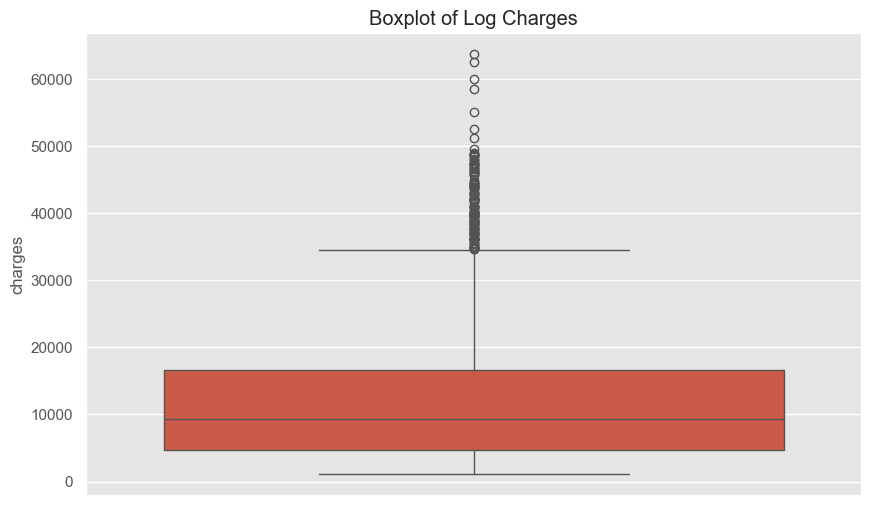

In [62]:
sb.boxplot(regression_dataset['charges'])
plt.title('Boxplot of Log Charges')
plt.show()

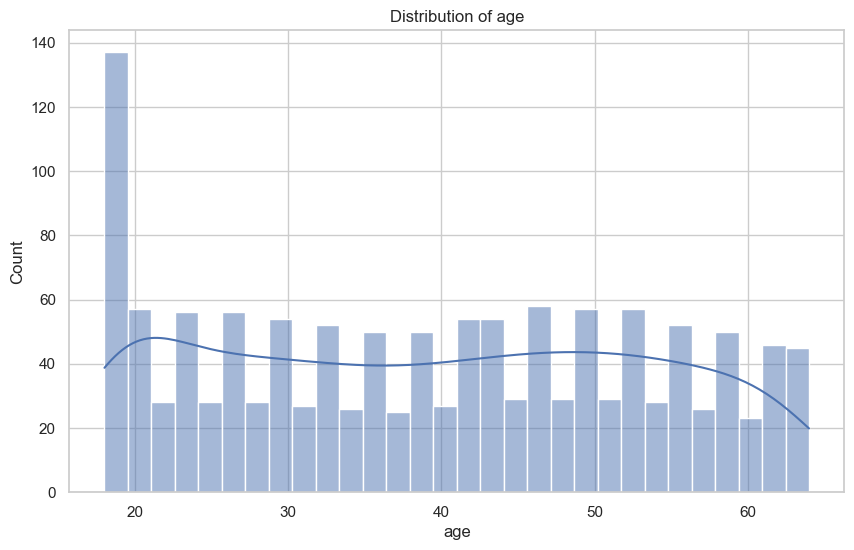

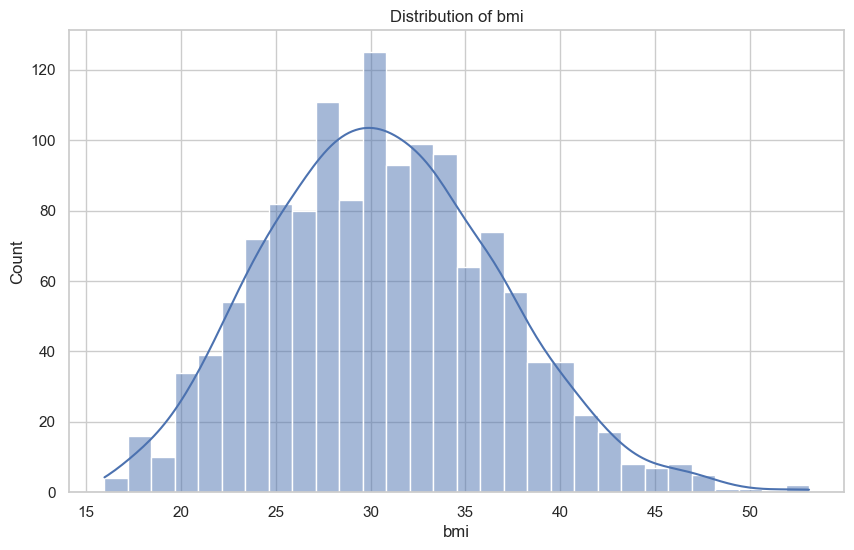

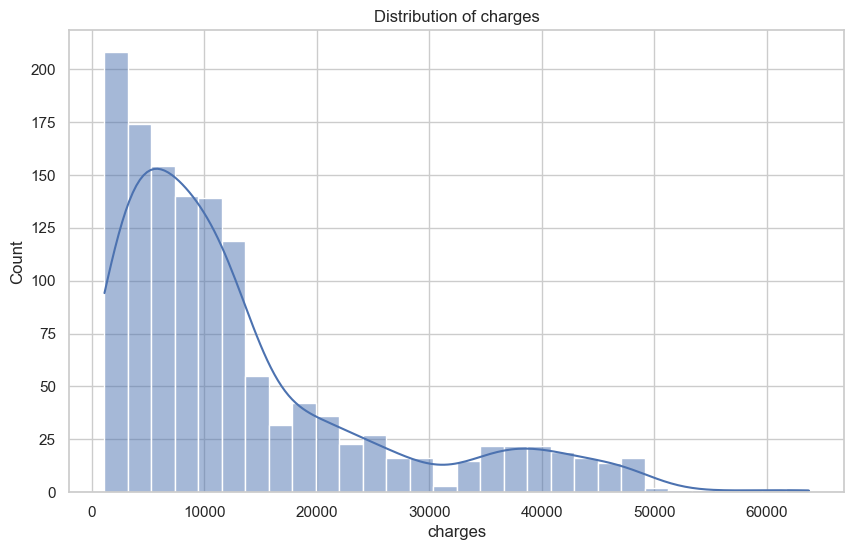

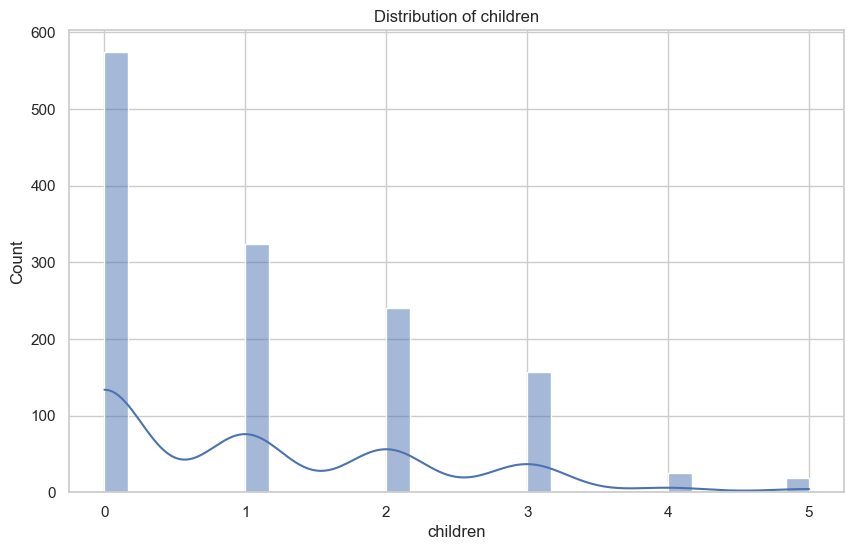

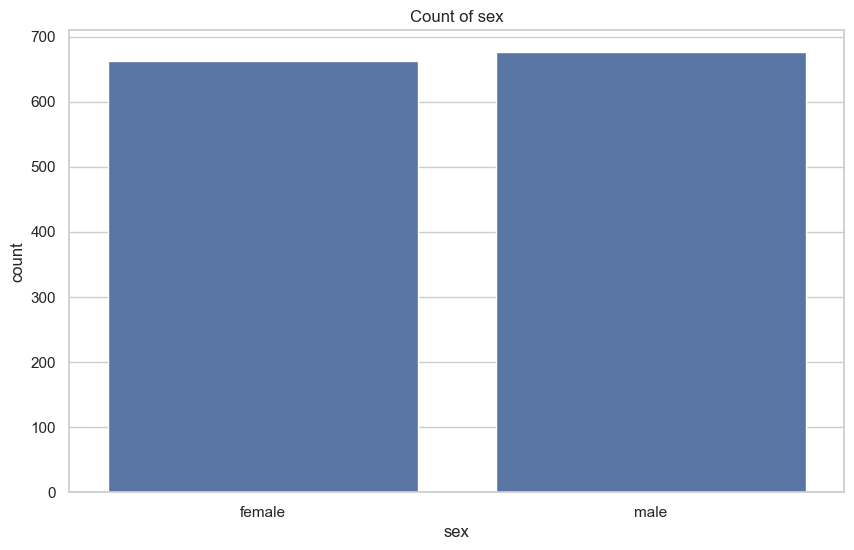

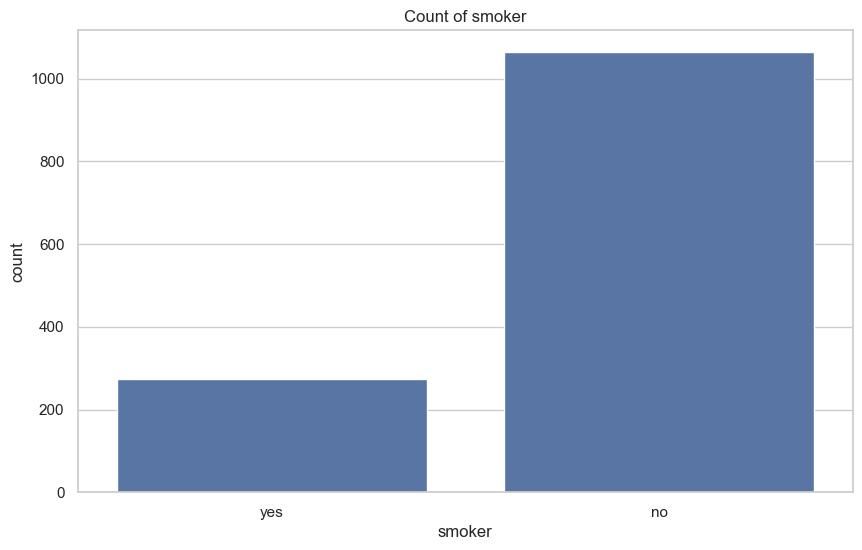

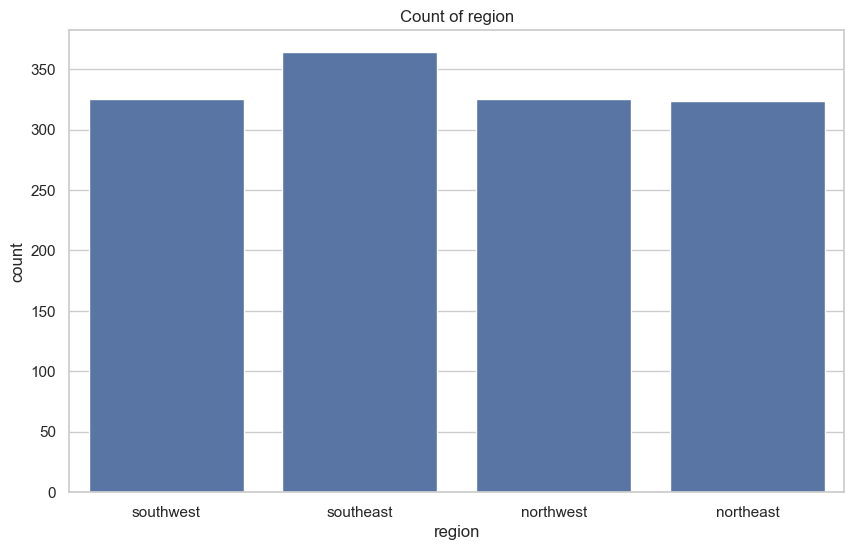

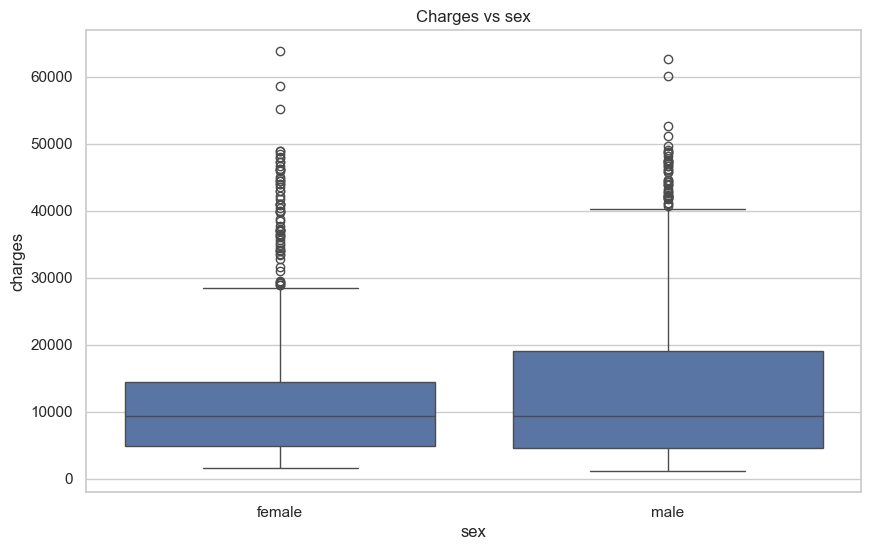

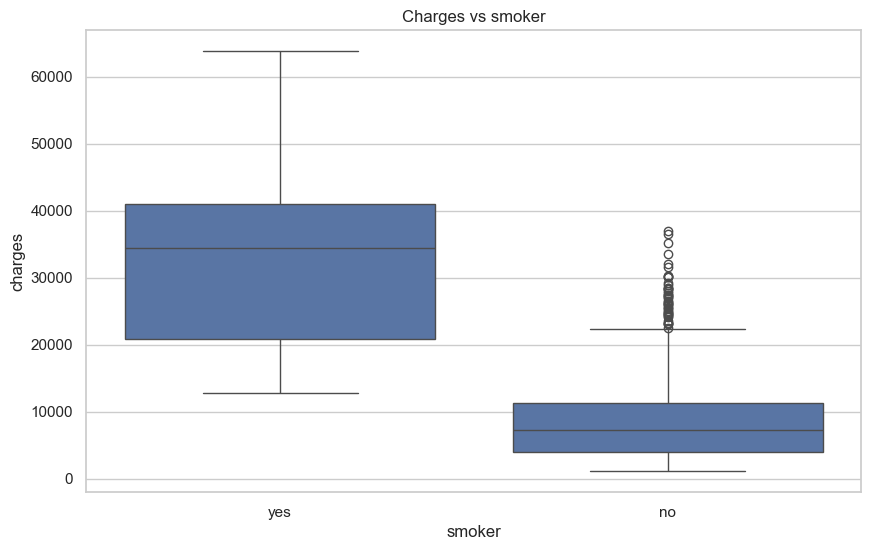

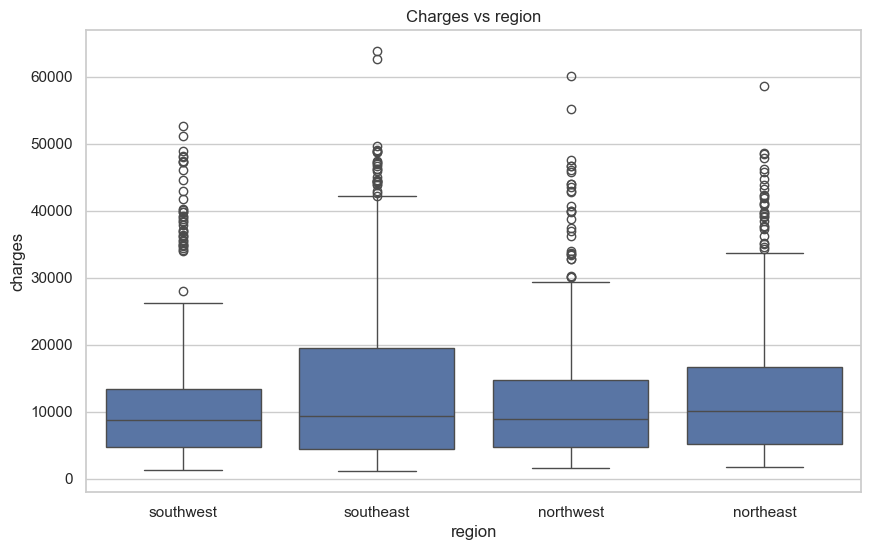

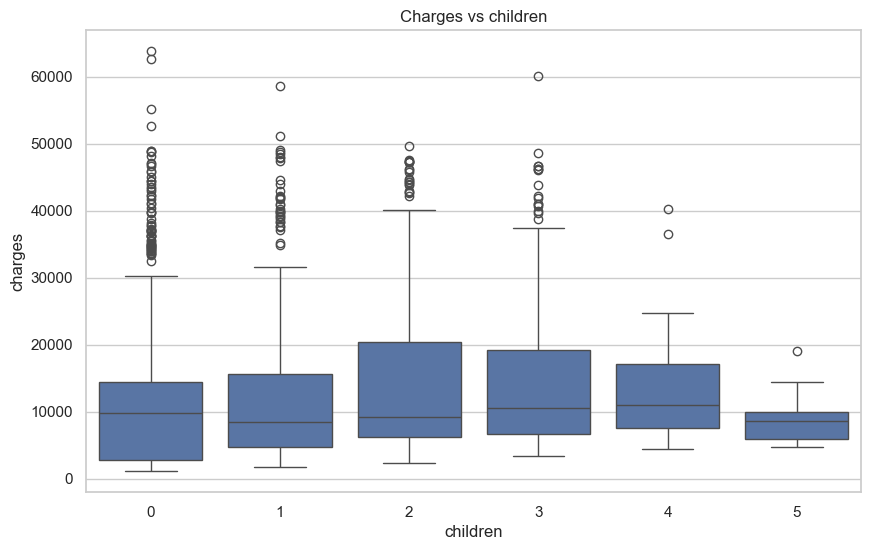

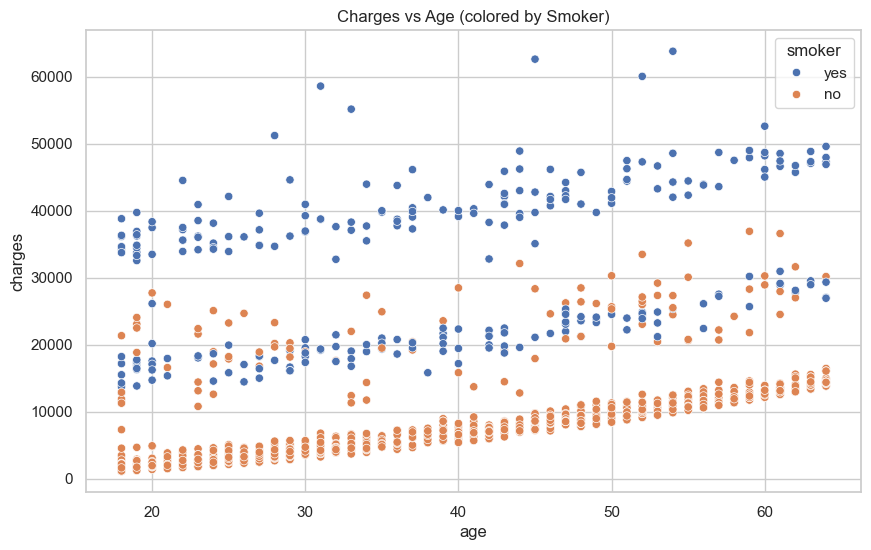

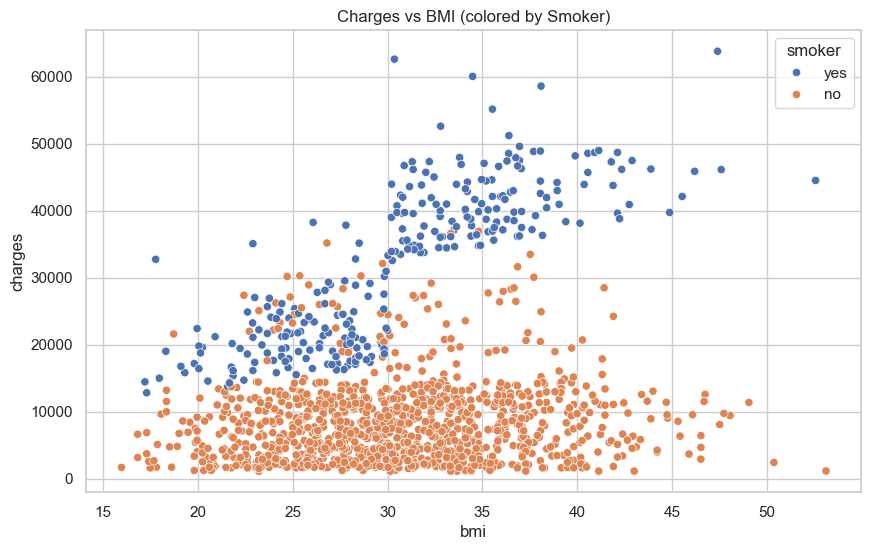

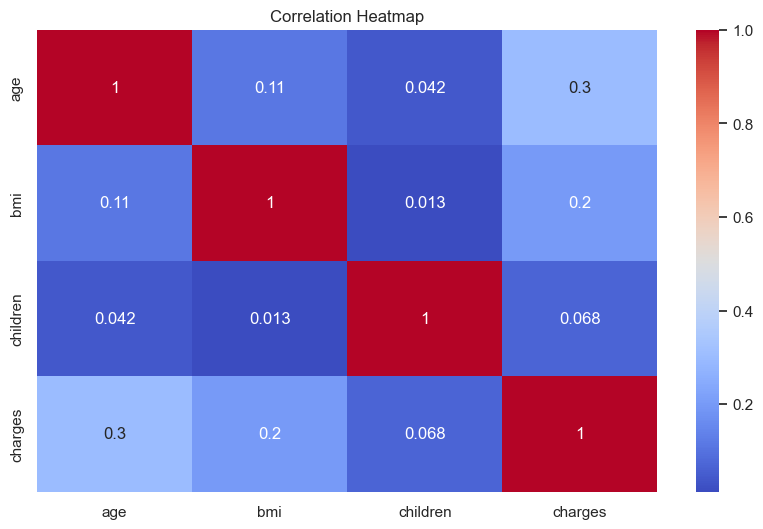

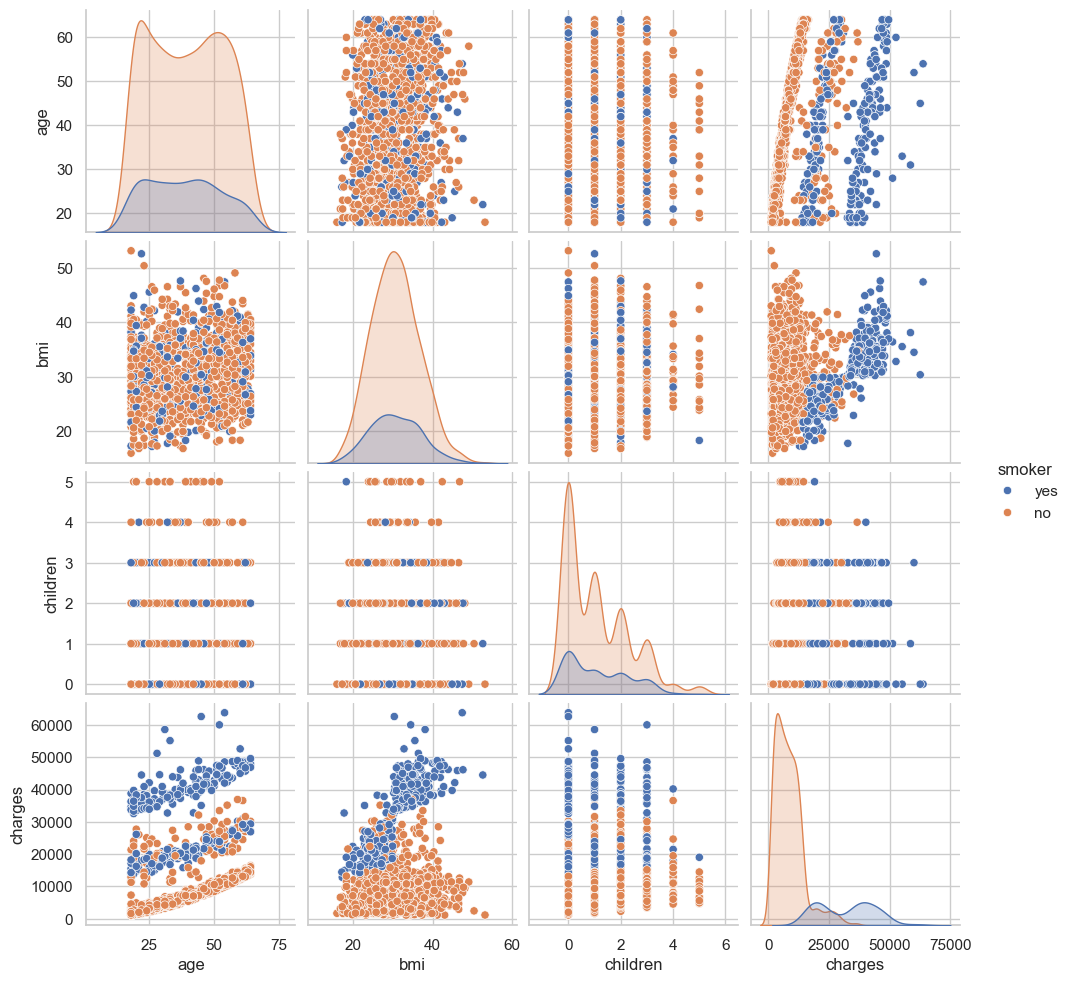

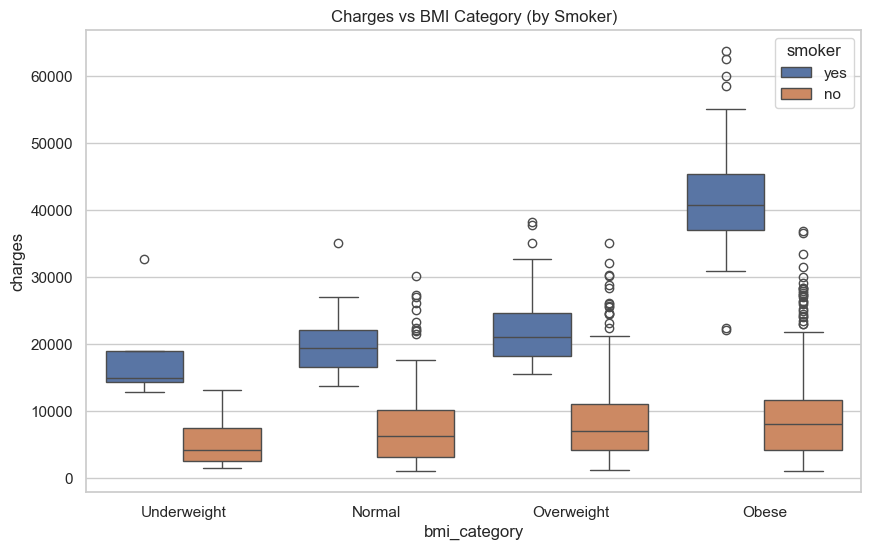

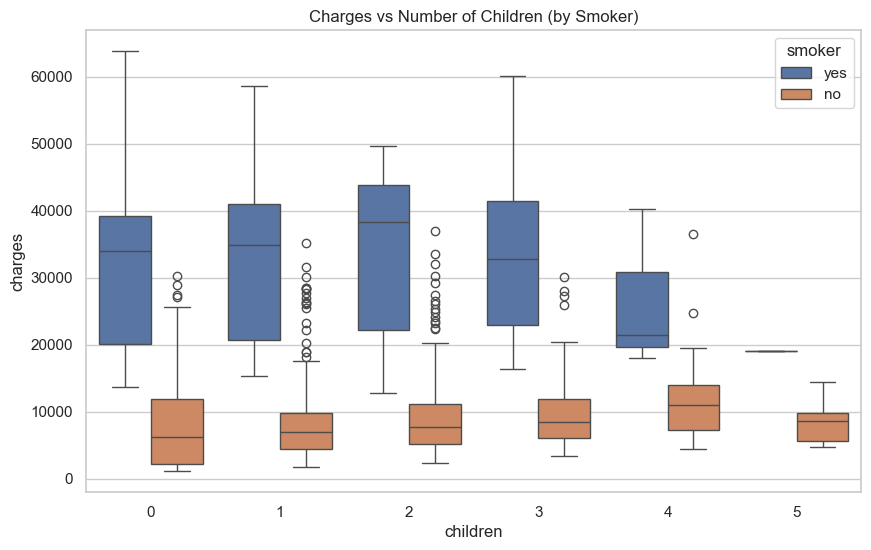

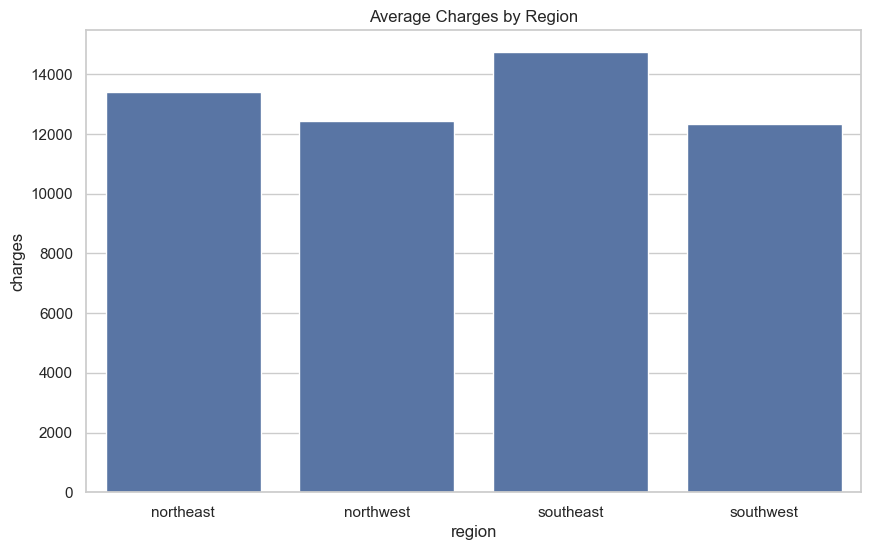

In [63]:
regression_dataset2 = pd.read_csv('./data/medical insurance/insurance.csv')

sb.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

numeric_cols = ['age', 'bmi', 'charges', 'children']
for col in numeric_cols:
    plt.figure()
    sb.histplot(regression_dataset2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    plt.figure()
    sb.countplot(x=col, data=regression_dataset2)
    plt.title(f'Count of {col}')
    plt.show()

for col in ['sex', 'smoker', 'region', 'children']:
    plt.figure()
    sb.boxplot(x=col, y='charges', data=regression_dataset2)
    plt.title(f'Charges vs {col}')
    plt.show()

plt.figure()
sb.scatterplot(x='age', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Age (colored by Smoker)')
plt.show()

plt.figure()
sb.scatterplot(x='bmi', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI (colored by Smoker)')
plt.show()

plt.figure()
sb.heatmap(regression_dataset2[['age','bmi','children','charges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sb.pairplot(regression_dataset2[['age','bmi','children','charges','smoker']], hue='smoker')
plt.show()


bins = [0, 18.5, 24.9, 29.9, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
regression_dataset2['bmi_category'] = pd.cut(regression_dataset2['bmi'], bins=bins, labels=labels)

plt.figure()
sb.boxplot(x='bmi_category', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs BMI Category (by Smoker)')
plt.show()

plt.figure()
sb.boxplot(x='children', y='charges', hue='smoker', data=regression_dataset2)
plt.title('Charges vs Number of Children (by Smoker)')
plt.show()

region_avg = regression_dataset2.groupby('region')['charges'].mean().reset_index()
plt.figure()
sb.barplot(x='region', y='charges', data=region_avg)
plt.title('Average Charges by Region')
plt.show()


In [64]:
regression_dataset['sex'] = regression_dataset['sex'].map({'male': 0,'female': 1})
regression_dataset['smoker'] = regression_dataset['smoker'].map({'no': 0,'yes': 1})
regression_dataset['region'] = regression_dataset['region'].map({'southwest': 0,'northwest': 1,'northeast': 2,'southeast': 3})
print(regression_dataset['region'].unique())
print(regression_dataset.isna().sum())

[0 3 1 2]
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [65]:
y = regression_dataset['charges']
X = regression_dataset.drop('charges', axis=1)

<h3>Testing log charges for skewing</h3>

In [66]:
import numpy as np

In [67]:
y_log = np.log1p(y)

<h3>Extracting Polynomial Features</h3>

In [68]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
numeric_poly = ['age', 'bmi']
poly_vals = poly.fit_transform(X[numeric_poly])

poly_df = pd.DataFrame(
    poly_vals, 
    columns=poly.get_feature_names_out(numeric_poly),
    index=X.index
)
poly_df = poly_df.drop(['age', 'bmi', 'age bmi'], axis=1)

#add latter or dont xD
X = pd.concat([X, poly_df], axis=1)


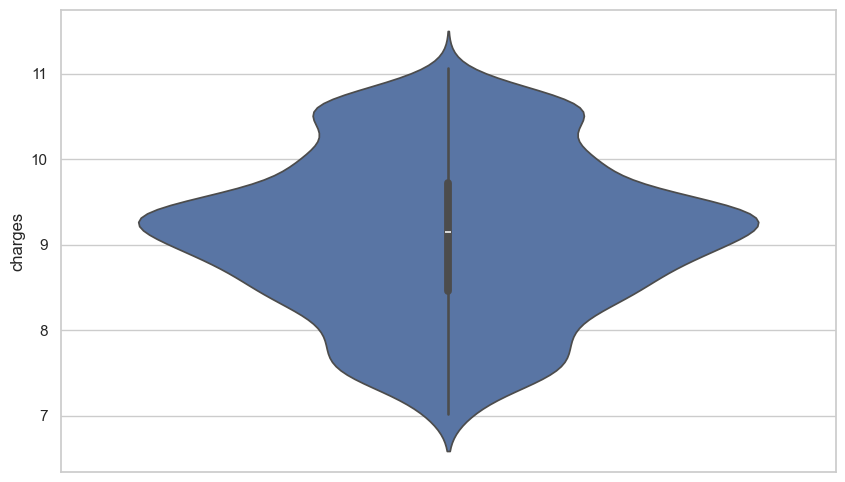

In [69]:
ax3 = sb.violinplot(data=y_log)

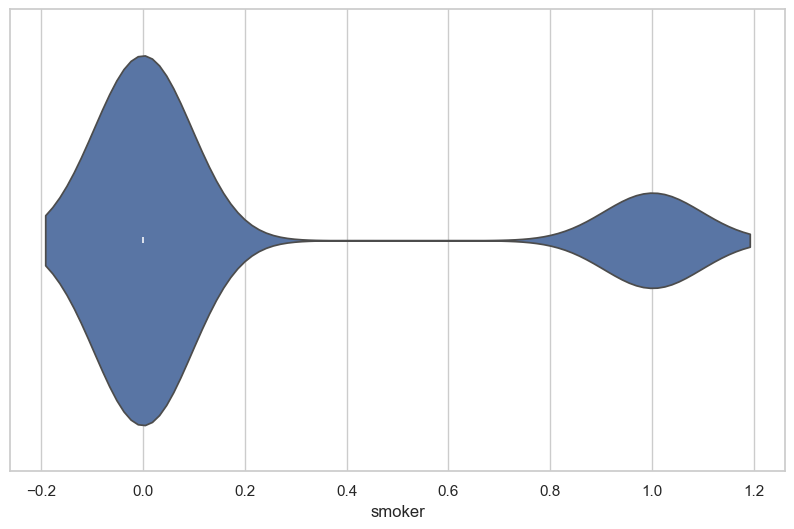

In [70]:
ax1 = sb.violinplot(x='smoker', data=regression_dataset)

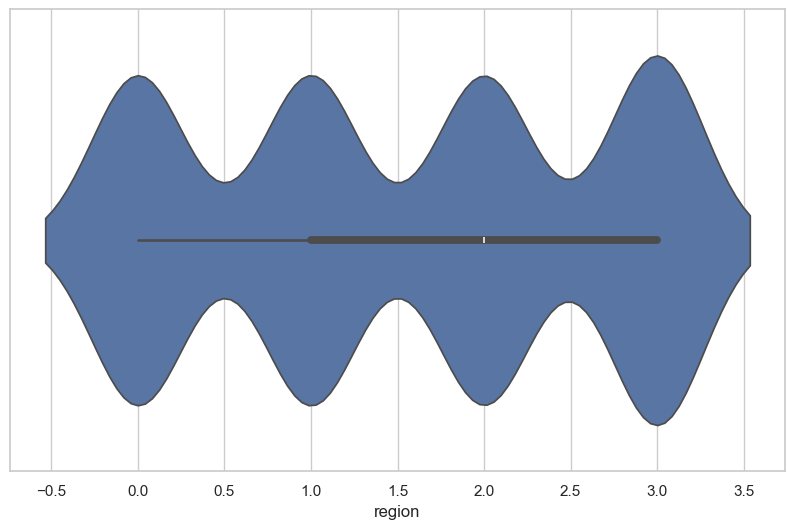

In [71]:
ax1 = sb.violinplot(x='region', data=regression_dataset)

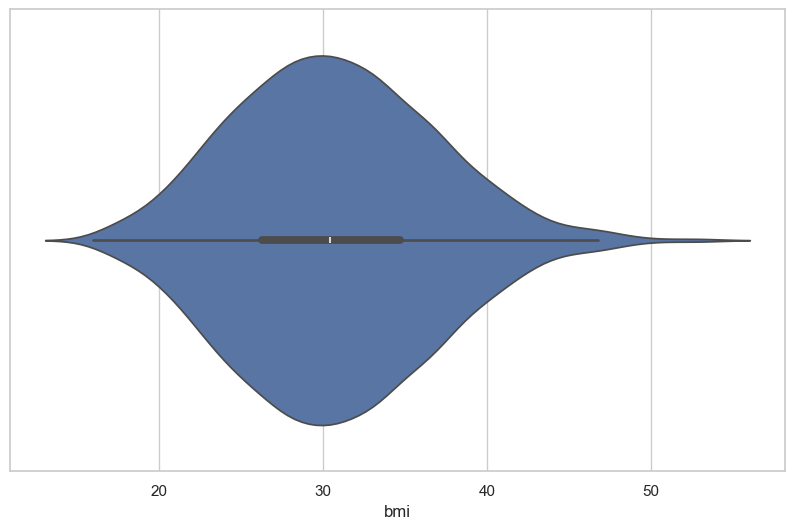

In [72]:
ax1 = sb.violinplot(x='bmi', data=regression_dataset)

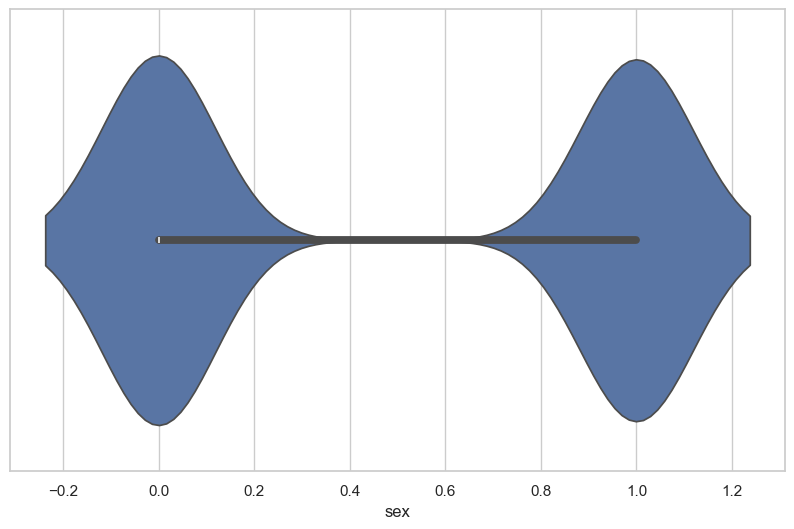

In [73]:
ax1 = sb.violinplot(x='sex', data=regression_dataset)

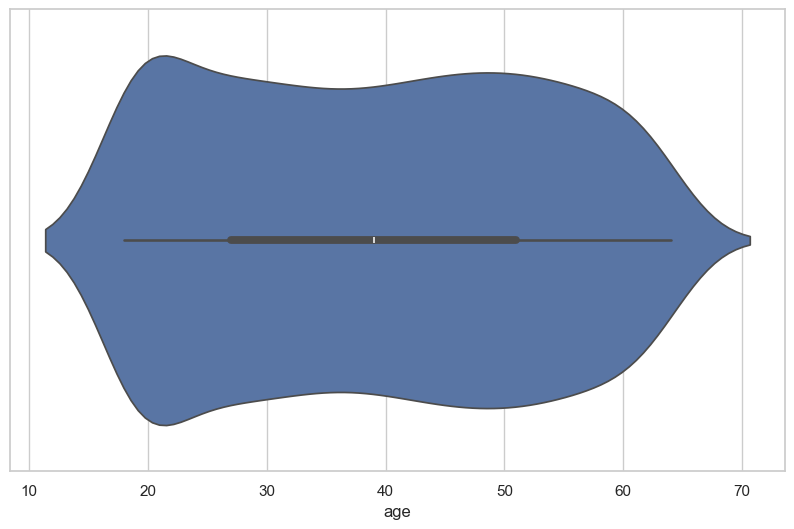

In [74]:
ax1 = sb.violinplot(x='age', data=regression_dataset)

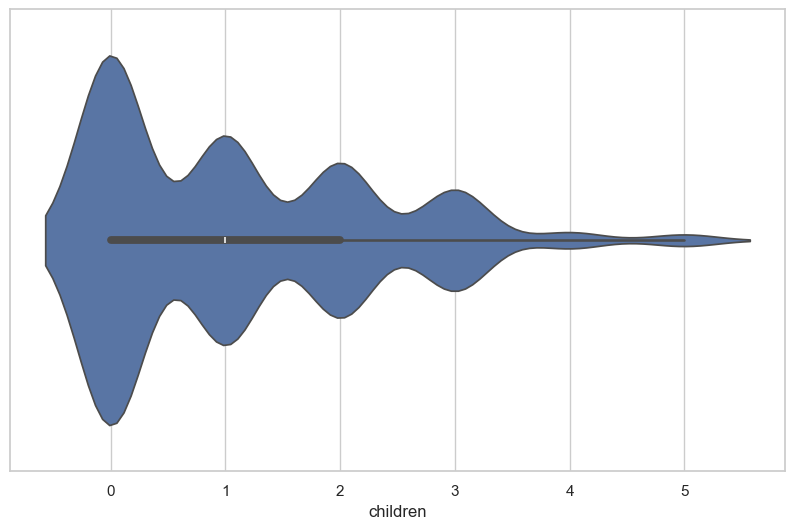

In [75]:
ax2 = sb.violinplot(x='children', data=regression_dataset)

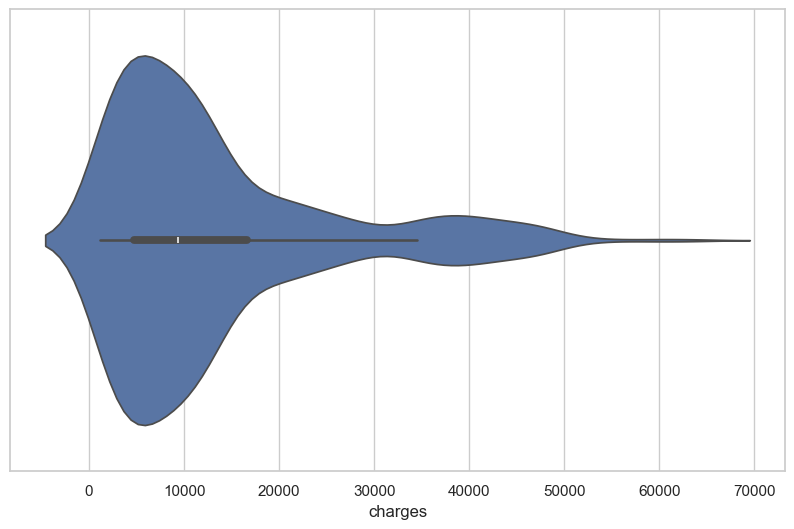

In [76]:
ax3 = sb.violinplot(x='charges', data=regression_dataset)

<h3>Correlation Analysis</h3>
PRedictors are weakly correlated between each other but there is significant impact of age and smoking on the charges size.

In [77]:
!pip install Jinja2

In [78]:
#different corr
corr = regression_dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

In [79]:
corr2 = regression_dataset.corr(method='kendall')
corr2.style.background_gradient(cmap='coolwarm')

In [80]:
corr3 = regression_dataset.corr(method='spearman')
corr3.style.background_gradient(cmap='coolwarm')

<h2>Feature Engineering</h2>

In [81]:
regression_dataset.tail()

age  sex    bmi  children  smoker  region     charges
1333   50    0  30.97         3       0       1  10600.5483
1334   18    1  31.92         0       0       2   2205.9808
1335   18    1  36.85         0       0       3   1629.8335
1336   21    1  25.80         0       0       0   2007.9450
1337   61    1  29.07         0       1       1  29141.3603

In [82]:
X.tail()

age  sex    bmi  children  smoker  region   age^2      bmi^2
1333   50    0  30.97         3       0       1  2500.0   959.1409
1334   18    1  31.92         0       0       2   324.0  1018.8864
1335   18    1  36.85         0       0       3   324.0  1357.9225
1336   21    1  25.80         0       0       0   441.0   665.6400
1337   61    1  29.07         0       1       1  3721.0   845.0649

In [83]:
age_bins = [0, 25, 35, 45, 55, 65, 100]  # 0-25, 26-35, etc.
age_labels = ["0_25", "26_35", "36_45", "46_55", "56_65", "65"]
X["age_group"] = pd.cut(X["age"], bins=age_bins, labels=age_labels, right=True)

bmi_bins = [0, 18.5, 24.9, 29.9, 100]  # underweight, normal, overweight, obese
bmi_labels = ["underweight", "normal", "overweight", "obese"]
X["bmi_category"] = pd.cut(X["bmi"], bins=bmi_bins, labels=bmi_labels, right=True)


In [84]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [85]:
X.tail()

age  sex    bmi  children  smoker  region   age^2      bmi^2 age_group  \
1333   50    0  30.97         3       0       1  2500.0   959.1409     46_55   
1334   18    1  31.92         0       0       2   324.0  1018.8864      0_25   
1335   18    1  36.85         0       0       3   324.0  1357.9225      0_25   
1336   21    1  25.80         0       0       0   441.0   665.6400      0_25   
1337   61    1  29.07         0       1       1  3721.0   845.0649     56_65   

     bmi_category  
1333        obese  
1334        obese  
1335        obese  
1336   overweight  
1337   overweight

In [86]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on numeric features of X
X_numeric_scaled = scaler.fit_transform(X[numeric_features])

# Convert back to DataFrame if you want
X_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features, index=X.index)

# Replace original numeric columns with scaled values
X[numeric_features] = X_scaled_df

print(X.tail())

           age  sex       bmi  children  smoker  region   age^2      bmi^2  \
1333  0.768473    0  0.050297  1.580926       0       1  2500.0   959.1409   
1334 -1.509965    1  0.206139 -0.908614       0       2   324.0  1018.8864   
1335 -1.509965    1  1.014878 -0.908614       0       3   324.0  1357.9225   
1336 -1.296362    1 -0.797813 -0.908614       0       0   441.0   665.6400   
1337  1.551686    1 -0.261388 -0.908614       1       1  3721.0   845.0649   

     age_group bmi_category  
1333     46_55        obese  
1334      0_25        obese  
1335      0_25        obese  
1336      0_25   overweight  
1337     56_65   overweight  


<h3>Even though the smoker column is imbalanced, there is no stronge noise or overfitting risk</h3>

In [87]:
from sklearn.feature_selection import mutual_info_regression

imbalance_ratio = X['smoker'].value_counts(normalize=True)
mi = mutual_info_regression(X[['smoker']], y)

print(f"Imbalance ratio: {imbalance_ratio.to_dict()}")
print(f"Mutual information with target: {mi[0]:.4f}")

Imbalance ratio: {0: 0.7952167414050823, 1: 0.20478325859491778}
Mutual information with target: 0.3692


<h2>One hot encoding binary and nominal variables.</h2>

In [88]:
df_pandas_encoded = pd.get_dummies(X, columns=['sex', 'region', 'smoker', 'age_group', 'bmi_category'], drop_first=True)
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[['sex', 'region', 'smoker', 'age_group', 'bmi_category']])
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['sex', 'region', 'smoker', 'age_group', 'bmi_category']))

X = pd.concat([X.drop(['sex', 'region', 'smoker', 'age_group', 'bmi_category'], axis=1), one_hot_df], axis=1)


In [89]:
print(X.tail())

           age       bmi  children   age^2      bmi^2  sex_0  sex_1  region_0  \
1333  0.768473  0.050297  1.580926  2500.0   959.1409    1.0    0.0       0.0   
1334 -1.509965  0.206139 -0.908614   324.0  1018.8864    0.0    1.0       0.0   
1335 -1.509965  1.014878 -0.908614   324.0  1357.9225    0.0    1.0       0.0   
1336 -1.296362 -0.797813 -0.908614   441.0   665.6400    0.0    1.0       1.0   
1337  1.551686 -0.261388 -0.908614  3721.0   845.0649    0.0    1.0       0.0   

      region_1  region_2  ...  smoker_1  age_group_0_25  age_group_26_35  \
1333       1.0       0.0  ...       0.0             0.0              0.0   
1334       0.0       1.0  ...       0.0             1.0              0.0   
1335       0.0       0.0  ...       0.0             1.0              0.0   
1336       0.0       0.0  ...       0.0             1.0              0.0   
1337       1.0       0.0  ...       1.0             0.0              0.0   

      age_group_36_45  age_group_46_55  age_group_56_65 

<h3>Train test validation split</h3>

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                   test_size=0.30, 
                                   shuffle=True,
                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                   test_size=0.50, 
                                   shuffle=True,
                                   random_state=42)

<h3>Should we scale and/or normalize the data?</h3>
Not really. It may distort feature importances and make interpretability harder. Decision trees and ensemble methods built from them split data based on feature thresholds. However for the sake of xgboost we will do this

<h2>Model training - Deep Neural Network, XGBoost Regression, Ensemble Random Forest Regressor</h2>

In [91]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

<h2>Random Forest Model</h2>

In [92]:
tree_regressor = RandomForestRegressor(max_depth=4, random_state=42, bootstrap=True, oob_score=True, n_jobs=8)
tree_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_jobs=8, oob_score=True, random_state=42)

In [93]:
from sklearn.model_selection import cross_val_score

y_pred = tree_regressor.predict(X_test)

y_pred_log = np.expm1(y_pred)

mse = mean_squared_error(np.expm1(y_test), y_pred_log)
mae = mean_absolute_error(np.expm1(y_test), y_pred_log)
mape = mean_absolute_percentage_error(np.expm1(y_test), y_pred_log)
r2 = r2_score(np.expm1(y_test), y_pred_log)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"R2 Error: {r2:.4f}")


Mean Squared Error: 20744908.4791
Mean Absolute Error: 2251.7616
Mean Absolute Percentage Error: 0.1824
R2 Error: 0.8632


In [94]:
!pip install optuna

In [95]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, KFold

Tuning of the model

In [96]:
def objective(trial):
    params ={
        'max_depth': trial.suggest_int("max_depth", 3, 32, log=True),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 10),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.01, 0.50),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.01, 0.99),
    }

    clf=RandomForestRegressor(**params, random_state=42, bootstrap=True, oob_score=True, n_jobs=8)
    clf.fit(X_train, y_train)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    #pred = clf.predict(X_val)
    #mse = mean_squared_error(y_val, pred)
    return -scores.mean()

In [97]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-12-20 13:52:42,733] A new study created in memory with name: no-name-94c6f8cd-4748-4b6d-9de1-6373b5714e2d


[I 2025-12-20 13:52:44,420] Trial 0 finished with value: 0.7403661605979612 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 0.036990256142400424, 'min_weight_fraction_leaf': 0.0626341824883756, 'ccp_alpha': 0.45440654437756195}. Best is trial 0 with value: 0.7403661605979612.
[I 2025-12-20 13:52:45,677] Trial 1 finished with value: 0.6419793837442864 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 0.27967691402679334, 'min_weight_fraction_leaf': 0.08274415121390603, 'ccp_alpha': 0.1297442337240483}. Best is trial 1 with value: 0.6419793837442864.
[I 2025-12-20 13:52:48,768] Trial 2 finished with value: 0.5656825753867524 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 0.010952353655296752, 'min_weight_fraction_leaf': 0.05602890792031075, 'ccp_alpha': 0.3395651048364249}. Best is trial 2 with value: 0.5656825753867524.
[I 2025-12-20 13:52:53,208] Trial 3 finished with value: 0.7419656488611571 and pa

In [98]:
print("Best random forest hyperparameters:", study.best_params)
print("Best random forest score:", study.best_value)

Best random forest hyperparameters: {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 0.02664383190326549, 'min_weight_fraction_leaf': 0.03483160308459848, 'ccp_alpha': 0.011367374252784996}
Best random forest score: 0.23904705977917953


In [99]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.7403661605979612, 0.6419793837442864, 0.5656825753867524,
                    0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.6472349005608644, 0.7419656488611571, 0.6261295521150796,
                    0.7419656488611571, 0.7419656488611571, 0.559096513896012,
                    0.667306805380051, 0.7419656488611571, 0.7419656488611572,
                    0.7419656488611571, 0.7419656488611571, 0.7419656488611571,
                    0.7138387868244364, 0.6417471211462175, 0.5429349779409975,
                    0.4385030953152329, 0.3704006708237055, 0.700901365093595,
                    0.6482769066740094, 0.73539210433257, 0.3658067228576197,
                    0.36601777372575384, 0.6460776902578017, 0.36601777372575384,
                    0.7419656488611571, 0.3659563053843404, 0.6491875862662033,
                    0.3662435563113389, 0.6465171989059175, 0.3658067228576198,
                    0.7419656488611571, 0.36708954417720874, 0.3651652576343544,
                    0.2415871447184908, 0.29516593987675205, 0.2412305128653501,
                    0.24144416000213814, 0.2404230561741459, 0.23904705977917953,
                    0.23982030367873106, 0.36672260573572857, 0.24106395240097095,
                    0.7419656488611571, 0.7419656488611571]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.7403661605979612, 0.6419793837442864, 0.5656825753867524,
                    0.5656825753867524, 0.5656825753867524, 0.5656825753867524,
                    0.5656825753867524, 0.5656825753867524, 0.5656825753867524,
                    0.5656825753867524, 0.5656825753867524, 0.559096513896012,
                    0.559096513896012, 0.559096513896012, 0.559096513896012,
                    0.559096513896012, 0.559096513896012, 0.559096513896012,
                    0.559096513896012, 0.559096513896012, 0.5429349779409975,
                    0.4385030953152329, 0.3704006708237055, 0.3704006708237055,
                    0.3704006708237055, 0.3704006708237055, 0.3658067228576197,
                    0.3658067228576197, 0.3658067228576197, 0.3658067228576197,
                    0.3658067228576197, 0.3658067228576197, 0.3658067228576197,
                    0.3658067228576197, 0.3658067228576197, 0.3658067228576197,
                    0.3658067228576197, 0.3658067228576197, 0.3651652576343544,
                    0.2415871447184908, 0.2415871447184908, 0.2412305128653501,
                    0.2412305128653501, 0.2404230561741459, 0.23904705977917953,
                    0.23904705977917953, 0.23904705977917953, 0.23904705977917953,
                    0.23904705977917953, 0.23904705977917953]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [100]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [max_depth (IntDistribution):
                                0.023139833255311278<extra></extra>,
                                min_samples_split (IntDistribution):
                                0.029778375078237038<extra></extra>,
                                min_weight_fraction_leaf (FloatDistribution):
                                0.09635282626480794<extra></extra>,
                                min_samples_leaf (FloatDistribution):
                                0.31577542223322014<extra></extra>, ccp_alpha
                                (FloatDistribution):
                                0.5349535431684237<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.02, 0.03, 0.10, 0.32, 0.53],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.023139833255311278, 0.029778375078237038,
                    0.09635282626480794, 0.31577542223322014, 0.5349535431684237],
              'y': [max_depth, min_samples_split, min_weight_fraction_leaf,
                    min_samples_leaf, ccp_alpha]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

<h3>Random Forest Results Validation</h3>

In [101]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)
best_random_model.fit(X_train, y_train)

random_pred = best_random_model.predict(X_train)

random_pred_log = np.expm1(random_pred)

random_mae = mean_absolute_error(np.expm1(y_train), random_pred_log)
random_mape = mean_absolute_percentage_error(np.expm1(y_train), random_pred_log)
random_r2 = r2_score(np.expm1(y_train), random_pred_log)
print("Random Forest Training MAE: ", random_mae)
print("Random Forest Training MAPE: ", random_mape)
print("Random Forest Training R2: ", random_r2)

val_pred = best_random_model.predict(X_val)

val_pred_log = np.expm1(val_pred)

val_mae = mean_absolute_error(np.expm1(y_val), val_pred_log)
random_mape = mean_absolute_percentage_error(np.expm1(y_val), val_pred_log)
random_r2 = r2_score(np.expm1(y_val), val_pred_log)
print("Random Forest Validation MAE: ", val_mae)
print("Random Forest Validation MAPE: ", random_mape)
print("Random Forest Validation R2: ",random_r2)

Random Forest Training MAE:  2680.8755701259042
Random Forest Training MAPE:  0.21318612134642934
Random Forest Training R2:  0.8332529042430542
Random Forest Validation MAE:  2403.497063763889
Random Forest Validation MAPE:  0.21897766413470524
Random Forest Validation R2:  0.8561006917933253


In [102]:
def RFtest(best_model):
    test_pred = best_model.predict(X_test)

    test_pred_log = np.expm1(test_pred)
    test_mse = mean_squared_error(np.expm1(y_test), test_pred_log)
    test_mae = mean_absolute_error(np.expm1(y_test), test_pred_log)
    test_r2 = r2_score(np.expm1(y_test), test_pred_log)
    test_mape = mean_absolute_percentage_error(np.expm1(y_test), test_pred_log)

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2, test_pred]

RFtest(best_model=best_random_model)

Test MSE: 24392734.830310214
Test MAE: 2636.31988910841
Test R2: 0.8391502327510159
Test MAPE: 0.21092420100137618


[24392734.830310214,
 2636.31988910841,
 0.21092420100137618,
 0.8391502327510159,
 array([ 8.28103538,  9.42998551,  8.5059045 ,  9.42998551,  8.5059045 ,
        10.6271516 ,  8.3092024 , 10.6271516 , 10.6271516 ,  8.98614648,
         9.37247932,  8.91900793,  8.3092024 ,  9.36332928,  8.74871169,
         9.42998551,  8.47270582, 10.6271516 ,  8.5059045 ,  9.36332928,
         9.42998551, 10.6271516 ,  8.49049061,  9.0972746 ,  8.99187725,
         8.71010033,  9.37247932,  9.42998551,  8.92700794,  9.42998551,
         9.39382187,  9.42998551,  9.9395833 , 10.6271516 , 10.6271516 ,
         9.42998551, 10.6271516 ,  9.42998551, 10.6271516 ,  9.39382187,
         8.91900793,  9.39382187,  8.49722187,  9.42998551,  8.5059045 ,
         9.9395833 ,  9.39382187,  8.11906376,  7.65692917,  8.49201003,
         8.13816605,  9.37247932,  7.65692917,  8.89342843,  9.42998551,
        10.6271516 ,  8.92700794,  8.91900793,  8.91900793,  7.65692917,
         8.49909971,  9.42998551,  9.0972

In [92]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
std = np.std([tree.feature_importances_ for tree in best_random_model.estimators_], axis=0)


Feature importance of the model features

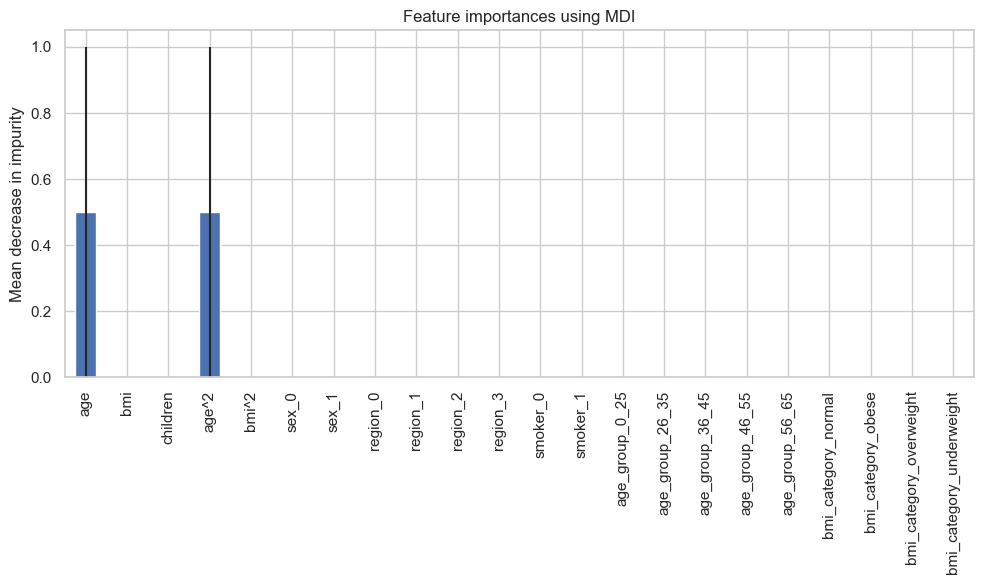

In [93]:
import pandas as pd
forest_importances = pd.Series(best_random_model.feature_importances_, index=list(X))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<h2>Training Random Forest on the best parameters</h2>

In [94]:
best_random_model = RandomForestRegressor(**study.best_params, random_state=42)

best_random_model.fit(X_train, y_train)

test_pred = best_random_model.predict(X_test)
test_mse = mean_squared_error(np.expm1(y_test), np.expm1(test_pred))
print("Test MSE:", test_mse)

Test MSE: 157958134.9601619


<h2>Linear Neural Network</h2>

In [95]:
!pip install torch

In [96]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import LeaveOneOut, KFold

<h4>Building and tuning the model</h4>
In order to achieve more dynamic results, we conduct training not only on hyperparameters but also another layer of training with number of layers and type of layers to automate architecture construction.

In [97]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

scaler = StandardScaler()
X_trainval = scaler.fit_transform(X_trainval)
X_test = scaler.transform(X_test)

X_trainval = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval = torch.tensor(y_trainval, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

INPUT_SIZE = X_trainval.shape[1]

class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_size, n_layers, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(n_layers):
            layers.extend([
                nn.Linear(in_dim, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_dim = hidden_size

        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def objective(trial):
    
    train_losses = []
    val_losses = []

    n_layers = trial.suggest_int("n_layers", 1, 6)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    N_EPOCHS = 40
    BATCH_SIZE = 64
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_mse = []

    for train_idx, val_idx in kf.split(X_trainval):
        X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_tr, y_val = y_trainval[train_idx], y_trainval[val_idx]

        train_loader = DataLoader(
            TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False
        )

        model = RegressionNet(
            INPUT_SIZE, hidden_size, n_layers, dropout_rate
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )
        criterion = nn.MSELoss()

        epoch_train_losses = []
        epoch_val_losses = []

        for _ in range(N_EPOCHS):
            model.train()
            running_loss = 0.0

            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device).unsqueeze(1)

                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
                
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        preds_all, targets_all = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                preds_all.append(model(xb.to(device)).cpu())
                targets_all.append(yb.unsqueeze(1))

        mse = mean_squared_error(
            torch.cat(targets_all).numpy(),
            torch.cat(preds_all).numpy()
        )
        fold_mse.append(mse)

    return np.mean(fold_mse)


In [98]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-12-20 12:47:51,187] A new study created in memory with name: no-name-7698ba43-1a0b-459f-a082-c2be08e39c79
[I 2025-12-20 12:48:32,070] Trial 0 finished with value: 319819836.8 and parameters: {'n_layers': 5, 'hidden_size': 32, 'dropout_rate': 0.3528034479652826, 'lr': 0.0012190722038121853, 'weight_decay': 2.954707251113425e-06}. Best is trial 0 with value: 319819836.8.
[I 2025-12-20 12:48:48,623] Trial 1 finished with value: 321473340.8 and parameters: {'n_layers': 1, 'hidden_size': 256, 'dropout_rate': 0.2784512309848185, 'lr': 0.00014923712229638245, 'weight_decay': 1.0559796595020395e-06}. Best is trial 0 with value: 319819836.8.
[I 2025-12-20 12:49:01,155] Trial 2 finished with value: 321900624.0 and parameters: {'n_layers': 1, 'hidden_size': 64, 'dropout_rate': 0.3315155643017386, 'lr': 0.00011353489399780141, 'weight_decay': 1.2039195587514106e-06}. Best is trial 0 with value: 319819836.8.
[I 2025-12-20 12:49:59,103] Trial 3 finished with value: 217167286.4 and parameters

In [99]:
print("Best params:", study.best_params)

best = study.best_params

final_model = RegressionNet(
    INPUT_SIZE,
    best["hidden_size"],
    best["n_layers"],
    best["dropout_rate"]
).to(device)

optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"]
)

criterion = nn.MSELoss()
train_loader = DataLoader(
    TensorDataset(X_trainval, y_trainval), batch_size=64, shuffle=True
)

for epoch in range(40):
    final_model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


Best params: {'n_layers': 2, 'hidden_size': 256, 'dropout_rate': 0.16828213450239743, 'lr': 0.009817042298482776, 'weight_decay': 3.055329251310769e-05}


Tuning performance

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

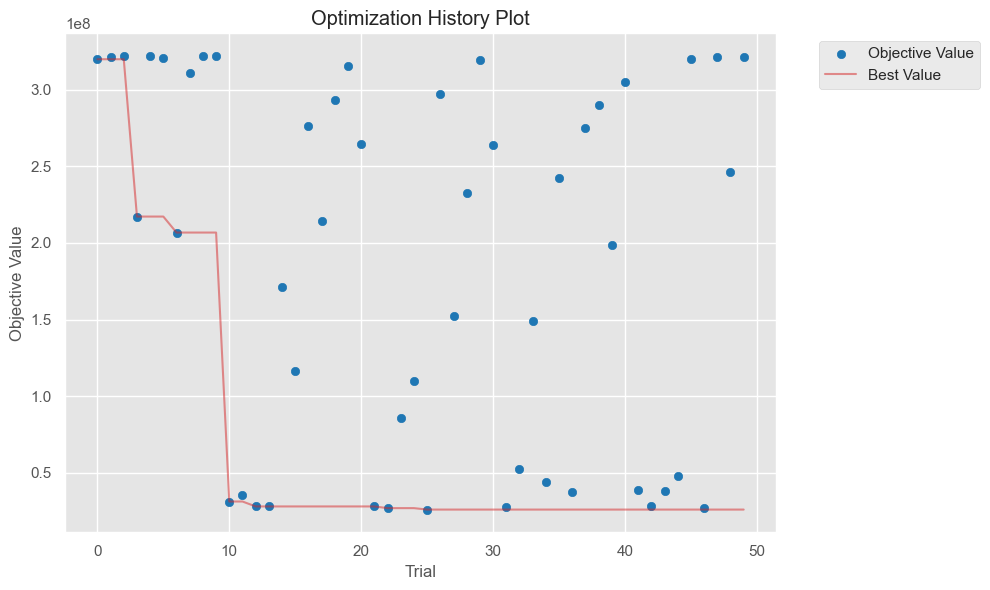

In [100]:
#optuna.visualization.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_optimization_history(study)

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

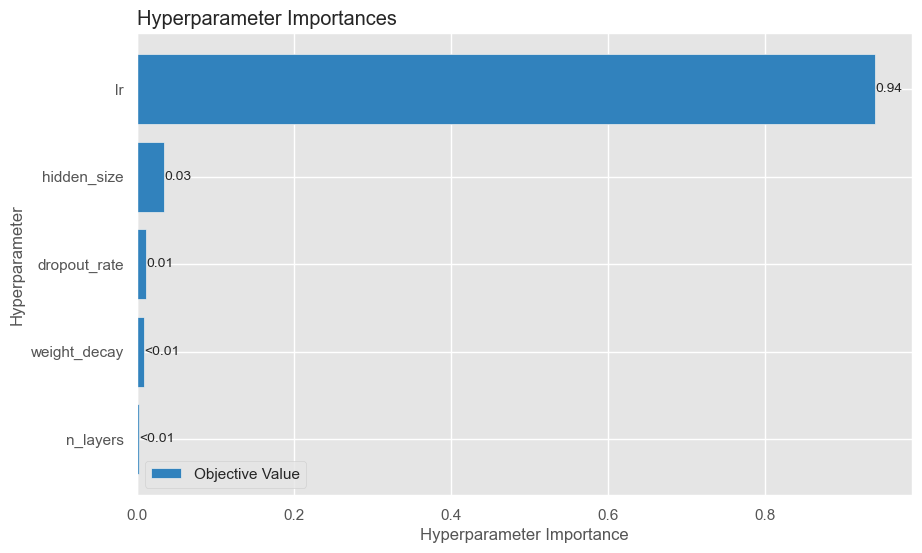

In [101]:
#optuna.visualization.plot_param_importances(study)
optuna.visualization.matplotlib.plot_param_importances(study)

Final results of training
The model did not outperform the classical ML models. It is also very expensive in computation and time consuming.

In [102]:
#y_train = torch.tensor(y_train.values, dtype=torch.float32)

final_model.eval()
with torch.no_grad():
    train_preds = final_model(X_trainval.to(device)).cpu().numpy()

train_mse = mean_squared_error(y_trainval.numpy(), train_preds)
train_mae = mean_absolute_error(y_trainval.numpy(), train_preds)
train_mape = mean_absolute_percentage_error(y_trainval.numpy(), train_preds)
train_r2 = r2_score(y_trainval.numpy(), train_preds)
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.4f}")
print(f"Train R2: {train_r2:.4f}")

Train MSE: 16338040.0000
Train MAE: 2219.5784
Train MAPE: 0.2460
Train R2: 0.8877


In [103]:
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test.to(device)).cpu().numpy()

test_mse = mean_squared_error(y_test.numpy(), test_preds)
test_mae = mean_absolute_error(y_test.numpy(), test_preds)
test_mape = mean_absolute_percentage_error(y_test.numpy(), test_preds)
test_r2 = r2_score(y_test.numpy(), test_preds)
print(f"TEST MSE: {test_mse:.4f}")
print(f"TEST MAE: {test_mae:.4f}")
print(f"TEST MAPE: {test_mape:.4f}")
print(f"TEST R2: {test_r2:.4f}")


TEST MSE: 22006014.0000
TEST MAE: 2585.1680
TEST MAPE: 0.2985
TEST R2: 0.8555


<h4>Network Structure</h4>

In [104]:
from torchinfo import summary

summary(final_model, input_size=(1, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
RegressionNet                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 256]                  5,888
│    └─BatchNorm1d: 2-2                  [1, 256]                  512
│    └─ReLU: 2-3                         [1, 256]                  --
│    └─Dropout: 2-4                      [1, 256]                  --
│    └─Linear: 2-5                       [1, 256]                  65,792
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─ReLU: 2-7                         [1, 256]                  --
│    └─Dropout: 2-8                      [1, 256]                  --
│    └─Linear: 2-9                       [1, 1]                    257
Total params: 72,961
Trainable params: 72,961
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.07
Input size (MB): 0.00
Forward/backw

In [105]:
final_model

RegressionNet(
  (network): Sequential(
    (0): Linear(in_features=22, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.16828213450239743, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.16828213450239743, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

<h4>Visualizing predictions of the model</h4>

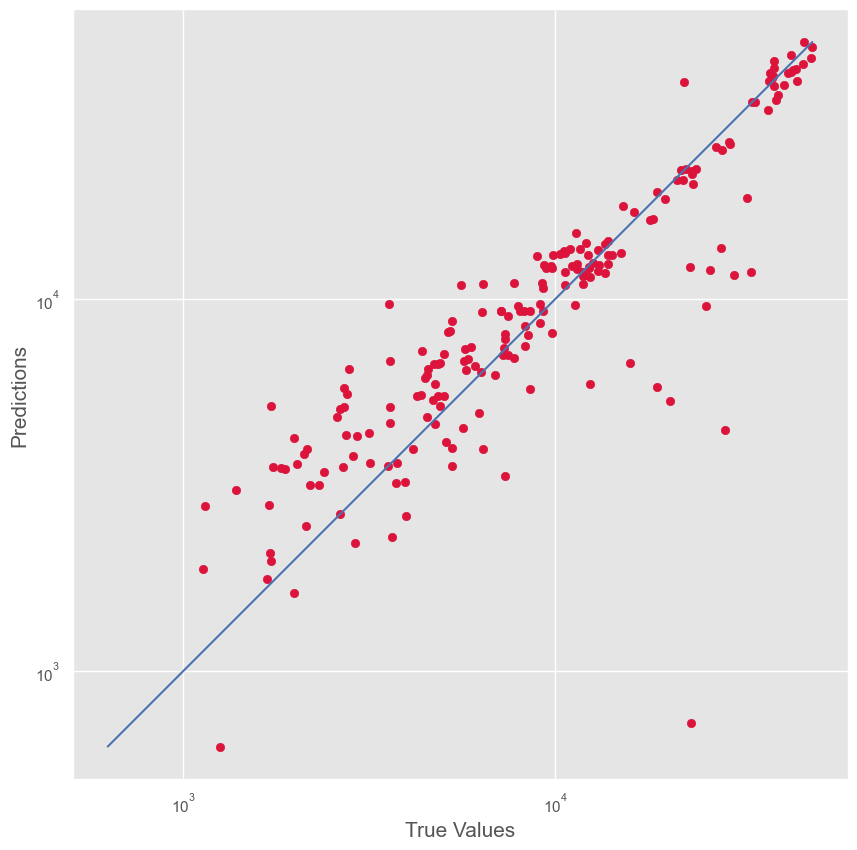

In [106]:
y_pred = test_preds.squeeze()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<h2>XGBoost Regressor</h2>

In [40]:
import xgboost

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                   test_size=0.30, 
                                   shuffle=True,
                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                   test_size=0.50, 
                                   shuffle=True,
                                   random_state=42)

<h3>Basic XGBoost Model</h3>

In [42]:
xgb_model = xgboost.XGBRegressor(n_estimators=10, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None, ...)

In [43]:
test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R2:", test_r2)

Test MSE: 0.22458192307345679
Test MAE: 0.3509803732678428
Test MAPE: 0.0392084661085726
Test R2: 0.7313933001925401


In [44]:
def xgb_objective(trial):
    params ={
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'eta': trial.suggest_float("eta", 0.1, 0.99),
        'subsample':  trial.suggest_float('subsample', 0.2, 0.99),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.1, 0.99),
        'gamma': trial.suggest_float('gamma', 0.1, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.99),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.99),
        #'booster': trial.suggest_categorical('booster', ['dart', 'linear'])

    }
    clf = xgboost.XGBRegressor(**params, random_state=42, n_jobs=8)
    clf.fit(X_train, y_train, verbose=True)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    return -scores.mean()

In [45]:
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=97)

[I 2025-12-20 13:35:19,116] A new study created in memory with name: no-name-3333dac2-f33d-49c0-bc0e-07f4c0708ffc
[I 2025-12-20 13:35:19,848] Trial 0 finished with value: 0.2811244260672545 and parameters: {'n_estimators': 338, 'max_depth': 2, 'eta': 0.9700433644673901, 'subsample': 0.6471220403466282, 'colsample_bytree': 0.1253587781130697, 'gamma': 0.4683827971107004, 'reg_alpha': 0.6792772461411056, 'reg_lambda': 0.48930159281954755}. Best is trial 0 with value: 0.2811244260672545.
[I 2025-12-20 13:35:20,313] Trial 1 finished with value: 0.22444757197172907 and parameters: {'n_estimators': 192, 'max_depth': 2, 'eta': 0.5172305958238048, 'subsample': 0.9013682662265905, 'colsample_bytree': 0.6710592836771736, 'gamma': 0.23476604561919154, 'reg_alpha': 0.9758551813132553, 'reg_lambda': 0.8012642464035373}. Best is trial 1 with value: 0.22444757197172907.
[I 2025-12-20 13:35:20,584] Trial 2 finished with value: 0.22710659020659887 and parameters: {'n_estimators': 112, 'max_depth': 2, '

<h3>Tuning Performance</h3>
Ignore the error message. The plot is executiong properly

In [47]:
optuna.visualization.plot_optimization_history(xgb_study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
              'y': [0.2811244260672545, 0.22444757197172907, 0.22710659020659887,
                    0.22229122356365588, 0.21364155781594193, 0.2865683828255977,
                    0.3325111077678103, 0.25834951072997386, 0.24128519410841873,
                    0.2745038097036613, 0.21187646512305292, 0.20860628166904766,
                    0.21320390081236812, 0.20189902418732583, 0.21129375914468987,
                    0.2758203330393377, 0.26055842016670383, 0.2387883714118561,
                    0.2127770316458218, 0.21147110647466522, 0.2416547327665557,
                    0.2068785364659765, 0.2073764417104685, 0.21633124292473535,
                    0.2072580738006377, 0.21102095797563752, 0.21489185060642776,
                    0.21847398169847984, 0.21670946025260007, 0.33243553220804223,
                    0.20388167825129985, 0.20259180969162788, 0.21934068596394907,
                    0.21023044968047544, 0.21179283398144033, 0.21917178816845656,
                    0.20785663708509236, 0.21198671430974012, 0.21683172350567528,
                    0.2117948547475934, 0.2415339235410891, 0.2097115367793342,
                    0.20707104922638347, 0.20574736258796683, 0.21871429159655092,
                    0.2052179345607103, 0.20953525032901815, 0.20775248148243416,
                    0.21935378617796694, 0.2136784112546708, 0.28344139058741297,
                    0.21132639402572978, 0.21820765761043473, 0.20401590753679946,
                    0.20688840489944135, 0.2065987841007606, 0.22757659446025774,
                    0.23167195437369084, 0.20936339300904666, 0.22812795451541162,
                    0.20549506441149212, 0.2066387796125862, 0.2057033951318839,
                    0.20534534078197106, 0.20672856509807208, 0.2110795139500215,
                    0.20864988899717773, 0.20837890947521887, 0.20595737646611942,
                    0.21576714807090483, 0.21120274068941175, 0.20432481788703566,
                    0.20459029744697738, 0.2047972755274415, 0.21745221266514786,
                    0.20371502221334897, 0.2054596694525968, 0.2023393360347491,
                    0.20253426841421965, 0.20486263186077042, 0.19962505963949137,
                    0.2042595277827969, 0.2032348199118969, 0.20867010117947887,
                    0.20999233647629506, 0.19968430132303427, 0.20955016140658658,
                    0.2062261113777848, 0.20919802004098292, 0.2797270697697182,
                    0.19888529272660663, 0.2026992171727274, 0.20160697398455074,
                    0.19982787367685298, 0.20251554954357776, 0.20018710871021078,
                    0.20208165349451485]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
              'y': [0.2811244260672545, 0.22444757197172907, 0.22444757197172907,
                    0.22229122356

In [48]:
optuna.visualization.plot_param_importances(xgb_study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [max_depth (IntDistribution):
                                0.00669901036256303<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.013966380879480836<extra></extra>, reg_alpha
                                (FloatDistribution):
                                0.01617842359605605<extra></extra>, gamma
                                (FloatDistribution):
                                0.020507862481705254<extra></extra>, n_estimators
                                (IntDistribution):
                                0.02160629019476446<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.02536035288489196<extra></extra>, eta
                                (FloatDistribution):
                                0.4003793296078239<extra></extra>, subsample
                                (FloatDistribution):
                                0.4953023499927145<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.40, 0.50],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.00669901036256303, 0.013966380879480836,
                    0.01617842359605605, 0.020507862481705254, 0.02160629019476446,
                    0.02536035288489196, 0.4003793296078239, 0.4953023499927145],
              'y': [max_depth, reg_lambda, reg_alpha, gamma, n_estimators,
                    colsample_bytree, eta, subsample]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

<h4>Choosing best model</h4>
It may differ slightly based on tuning loss function

In [49]:
trial = xgb_study.trials[93] #best set of parameters

In [50]:
best_xgb_model = xgboost.XGBRegressor(**trial.params, random_state=42)

In [51]:
import joblib

joblib.dump(best_xgb_model, "xgb1.joblib.dat")


['xgb1.joblib.dat']

<h4>Printing final results</h3>

In [118]:
from sklearn.metrics import root_mean_squared_error

loaded_model = joblib.load("xgb1.joblib.dat")
best_xgb_model.fit(X_train, y_train)

xgb_pred = best_xgb_model.predict(X_train)
xgb_mae = mean_absolute_error(np.expm1(y_train), np.expm1(xgb_pred))
xgb_mape = mean_absolute_percentage_error(np.expm1(y_train), np.expm1(xgb_pred))
xgb_r2 = r2_score(np.expm1(y_train), np.expm1(xgb_pred))

print("XGB TRAINING MAE: ", xgb_mae)
print("XGB TRAINING MAPE: ", xgb_mape)
print("XGB TRAINING R2: ", xgb_r2)

val_pred = best_xgb_model.predict(X_val)

val_mae = mean_absolute_error(np.expm1(y_val), np.expm1(val_pred))
val_mape = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(val_pred))
val_r2 = r2_score(np.expm1(y_val), np.expm1(val_pred))

print("XGB VAL MAE: ", val_mae)
print("XGB VAL MAPE: ", val_mape)
print("XGB VAL R2: ", val_r2)


XGB TRAINING MAE:  1833.7489251126392
XGB TRAINING MAPE:  0.12931564894497352
XGB TRAINING R2:  0.8901854936373185
XGB VAL MAE:  2033.268739182486
XGB VAL MAPE:  0.19418747931695649
XGB VAL R2:  0.869909627341066


In [119]:
test_pred = best_xgb_model.predict(X_test)

def XGBtest(best_model):
    test_pred = best_model.predict(X_test)

    test_mse = mean_squared_error(np.expm1(y_test), np.expm1(test_pred))
    test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(test_pred))
    test_r2 = r2_score(np.expm1(y_test), np.expm1(test_pred))
    test_mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(test_pred))

    print("Test MSE:", test_mse)
    print("Test MAE:", test_mae)
    print("Test R2:", test_r2)
    print("Test MAPE:", test_mape)

    return [test_mse, test_mae, test_mape, test_r2, test_pred]

XGBtest(best_model=best_xgb_model)

Test MSE: 20502245.275324497
Test MAE: 2143.6640692805504
Test R2: 0.8648047706188429
Test MAPE: 0.18533428744113292


[20502245.275324497,
 2143.6640692805504,
 0.18533428744113292,
 0.8648047706188429,
 array([ 8.108772 ,  9.551554 ,  8.607991 ,  9.45072  ,  8.574786 ,
        10.507719 ,  8.441618 , 10.614456 , 10.498761 ,  9.069211 ,
         9.286531 ,  8.872202 ,  8.498271 ,  9.217694 ,  8.846345 ,
         9.455352 ,  8.420869 , 10.617832 ,  8.463433 ,  9.178709 ,
         9.38216  , 10.697909 ,  8.060975 ,  9.066553 ,  9.157637 ,
         8.783305 ,  9.313542 ,  9.68972  ,  8.766573 ,  9.510581 ,
         9.263624 ,  9.561411 ,  9.865846 , 10.626385 , 10.395064 ,
         9.532725 , 10.59397  ,  9.43899  , 10.395064 ,  9.396142 ,
         8.789643 ,  9.3683405,  8.568797 ,  9.412315 ,  8.656853 ,
        10.105978 ,  9.399089 ,  8.429824 ,  7.298679 ,  8.4345045,
         9.712206 ,  9.342056 ,  7.5185275,  9.033143 ,  9.439935 ,
        10.605484 ,  8.768211 ,  8.975519 ,  8.978946 ,  7.3182316,
         8.5979395,  9.426324 ,  9.1366   ,  8.491975 ,  7.5705485,
         9.38216  ,  7.6470065,

The model explains 87% of variance, the average deviation from real value is 17%, which results in approximately $2011 of charge size deviation. Possible solutions to boost performance will be a tradeoff of removed outliers wihich in our case will remove information about the special cases of people, effectively masking their inclusion but boosting MAE/MAPE even further. The second option is to simply add new variable, for example education to better explain random elements. 

Test MSE: 20502245.275324497
Test MAE: 2143.6640692805504
Test R2: 0.8648047706188429
Test MAPE: 0.18533428744113292


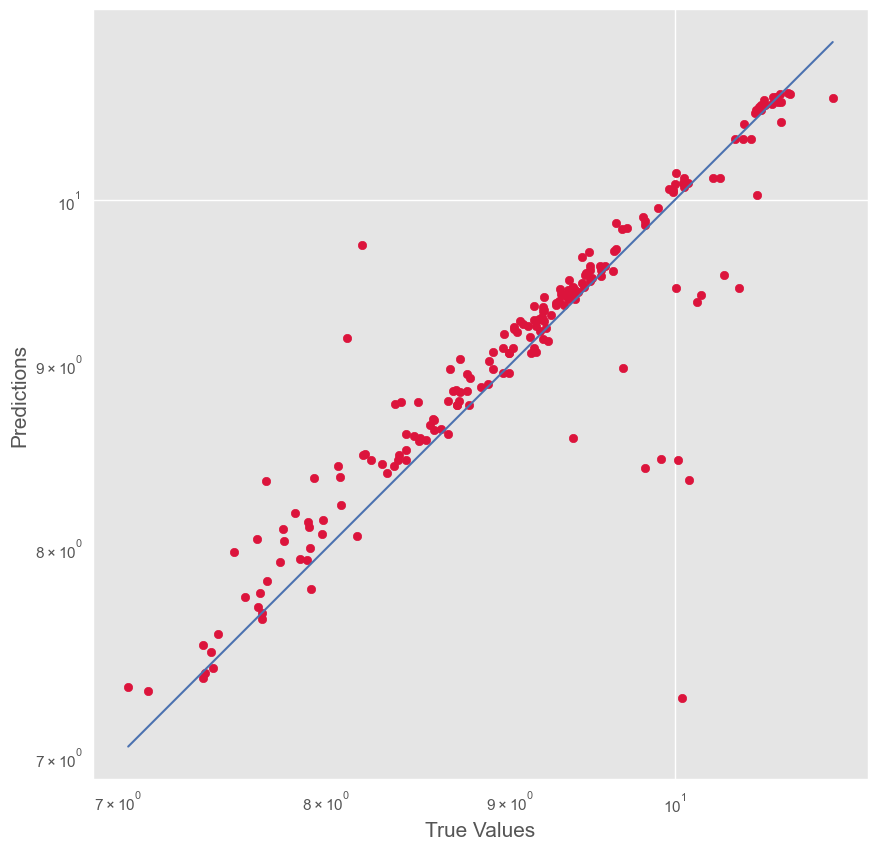

In [120]:
y_pred = XGBtest(best_xgb_model)

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred[4], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred[4]), max(y_test))
p2 = min(min(y_pred[4]), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

<h3>The model has interesting impact on the final results</h3> 
The SHAP plot will explain how each of variables affects final result.

In [121]:
!pip install shap scipy

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

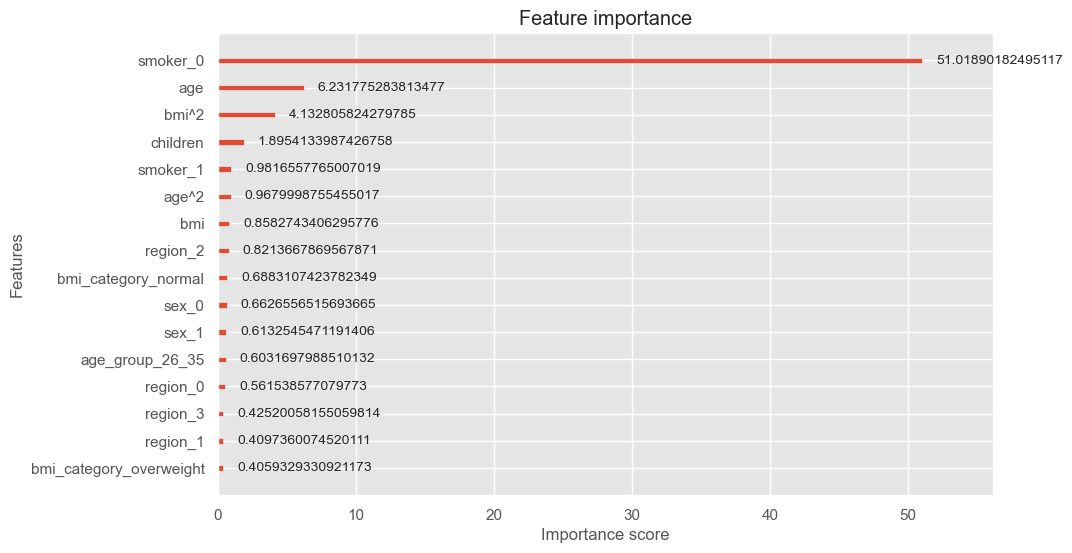

In [122]:
from xgboost import plot_importance
plot_importance(best_xgb_model, importance_type='gain')

<h3>Experimental part - training model on smaller number of predictors</h3>
Recursive feature elimination with cross-validation to select best set of features

In [52]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor

model = best_xgb_model
selector = RFECV(model, step=1, cv=5, scoring='neg_root_mean_squared_error')
selector.fit(X_train, y_train)
X_selected = X_train.loc[:, selector.support_]

<h3>Conducting tuning for XGBoost model</h3>

In [53]:
def xgb_objective_exp(trial):
    params ={
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'eta': trial.suggest_float("eta", 0.1, 0.99),
        'subsample':  trial.suggest_float('subsample', 0.2, 0.99),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.1, 0.99),
        'gamma': trial.suggest_float('gamma', 0.1, 0.99),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.99),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.99),
        #'booster': trial.suggest_categorical('booster', ['dart', 'linear'])

    }
    clf = xgboost.XGBRegressor(**params, random_state=42, n_jobs=8)
    clf.fit(X_selected, y_train, verbose=True)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_selected, y_train, cv=cv, scoring='neg_mean_absolute_error')

    return -scores.mean()

In [54]:
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective_exp, n_trials=97)

[I 2025-12-20 13:44:51,486] A new study created in memory with name: no-name-d6541169-0b38-459b-ab0b-0c50c55b6ac8
[I 2025-12-20 13:44:52,529] Trial 0 finished with value: 0.2500697479505162 and parameters: {'n_estimators': 458, 'max_depth': 7, 'eta': 0.8022715897022007, 'subsample': 0.6414094431191966, 'colsample_bytree': 0.43613919678634516, 'gamma': 0.4859670557149195, 'reg_alpha': 0.6945124290136705, 'reg_lambda': 0.15148211609817003}. Best is trial 0 with value: 0.2500697479505162.
[I 2025-12-20 13:44:53,483] Trial 1 finished with value: 0.2168176749042948 and parameters: {'n_estimators': 283, 'max_depth': 10, 'eta': 0.5907259925457099, 'subsample': 0.9564886990274695, 'colsample_bytree': 0.5523662092281619, 'gamma': 0.2880451148181278, 'reg_alpha': 0.3256964276594318, 'reg_lambda': 0.7969904064046588}. Best is trial 1 with value: 0.2168176749042948.
[I 2025-12-20 13:44:54,226] Trial 2 finished with value: 0.28214234950849554 and parameters: {'n_estimators': 202, 'max_depth': 10, '

<h3>Results of Tuning</h3>

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

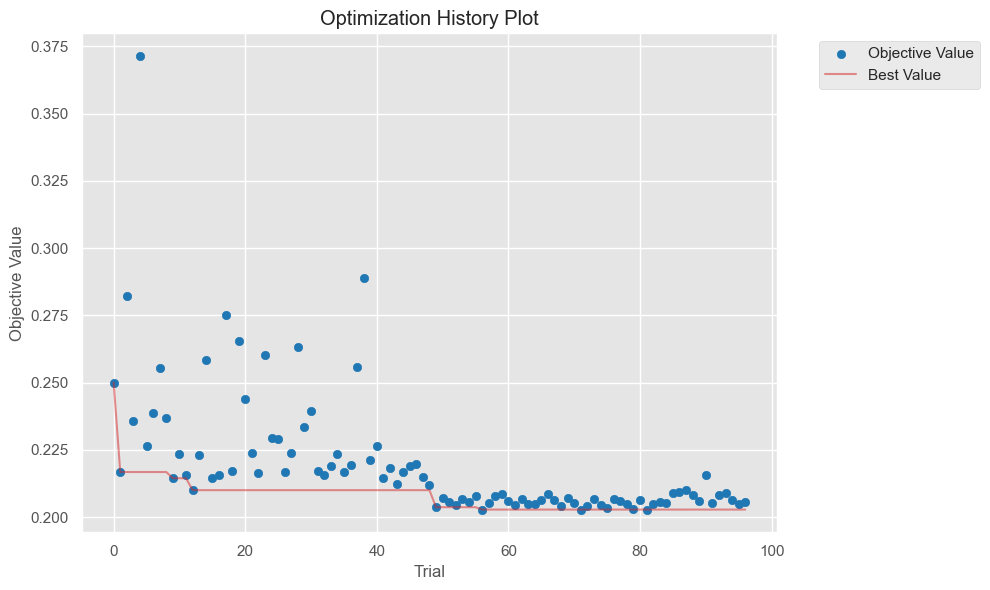

In [56]:
optuna.visualization.matplotlib.plot_optimization_history(xgb_study)

In [57]:
exp_xgb_model = xgboost.XGBRegressor(**trial.params, random_state=42)

<h3>The model does not improve upon removal of irrelevent features thus it won't be considered for final results</h3>

<h2>Models exporting</h2>
The models are exported: Random Forest and XGBoost to pickle and Neural Network to pt.

In [128]:
import pickle

#export of random forest
with open("./models/rf_regressor.pkl", "wb") as f:
    pickle.dump(best_random_model, f)

#export og nn
MODEL_PATH = "./models/regression_model.pt"

torch.save({
    "model_state_dict": final_model.state_dict(),
    "input_size": INPUT_SIZE
}, MODEL_PATH)

#export of xgboost regressor
with open("./models/xgb_regressor.pkl", "wb") as f:
    pickle.dump(best_xgb_model, f)

<h2>Pipelining</h2>
This part of code is constructing Pipelines for models to facilitate future development

In [129]:
xgb_pipeline = Pipeline([
    ('XGBRegressor', xgboost.XGBRegressor(**study.best_params, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

In [130]:
RF_pipeline = Pipeline([
    ('model', RandomForestRegressor(
        random_state=42,
        bootstrap=True,
        oob_score=True,
        n_jobs=8,
    ))
])

RF_pipeline.fit(X_train, y_train)
y_pred = RF_pipeline.predict(X_test)


<h3>Sources</h3>

Random Forest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://towardsdatascience.com/understanding-random-forest-using-python-scikit-learn/
- https://kirenz.github.io/regression/docs/randomforest.html

Neural Network
- https://www.kaggle.com/code/zahrazolghadr/neural-network-model-for-regression
- https://www.kaggle.com/code/zahrazolghadr/neural-network-model-for-regression
- https://www.d2l.ai/chapter_linear-regression/index.html

XGBoost
- https://www.geeksforgeeks.org/machine-learning/xgboost/
- https://xgboost.readthedocs.io/en/stable/

Data source:
- https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset

Insurance theory
- https://onlinelibrary.wiley.com/doi/abs/10.1002/asmb.2543
- https://www.mdpi.com/2227-9091/9/2/42
- https://www.researchgate.net/profile/Kofi-Jones/publication/371794479_The_Implementation_of_Machine_Learning_In_The_Insurance_Industry_With_Big_Data_Analytics/links/649c6d9d8de7ed28ba6180cc/The-Implementation-of-Machine-Learning-In-The-Insurance-Industry-With-Big-Data-Analytics.pdf
- https://link.springer.com/article/10.1007/s13385-019-00215-z